Don't need to show anything
Don't need to show anything


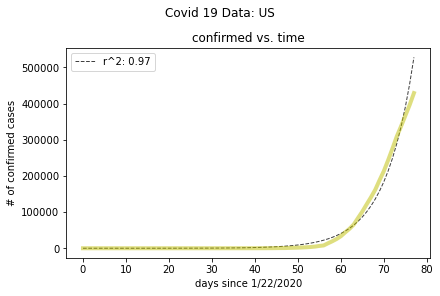

In [4]:
import tkinter as tk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
import dataset
import regression
import scrape

class Win1:
    def __init__(self, master):
        self.master = master
        self.master.geometry("500x500")
        self.frame = tk.Frame(self.master)
        self.data = dataset.Data()
        self.picks = ["Confirmed", "Deaths", "Recovered"]
        self.vars = []
        self.ticks = []
        # Elements for screen are added below
        # Dropdown menu here:
        self.tkvar = tk.StringVar(self.master) # variable for keeping track of what the user has currently selected
        self.choices = [k for k in self.data.confirmed_dict.keys()] # List of all available countries with data
        self.tkvar.set("US") # sets the default value to US
         # shows the menu on the screen
        self.tkvar.trace('w', self.change_dropdown) # tracing the current value
        # Search bar here:
        self.input = tk.StringVar(self.master)
        # Labels:
        self.pick = tk.Label(self.master, text="Pick a Country: ")
        self.enter = tk.Label(self.master, text="Enter a Country: ")
        # Dropdown Menu:
        self.popup = tk.OptionMenu(self.master, self.tkvar, *self.choices)
        # Search bar:
        self.search = tk.Entry(self.master, textvariable=self.input)
        # tickboxes:
        #
        for p in self.picks:
            var = tk.IntVar()
            chk = tk.Checkbutton(self.master, text=p,variable=var)
            self.ticks.append(chk)
            self.vars.append(var)
        # Update data button:
        self.update_data = tk.Button(self.master, text="Click here to update data", command = self.update)
        # View data button:
        self.view_data = tk.Button(self.master, text="Click here to view data", command = lambda: self.new_window("2", Win2))
        # # Quit button:
        self.quit = tk.Button(self.master, text="Click here to quit", command=self.close_window)
        # update window:
        self.pick.grid(row=0,column=1)
        self.popup.grid(row=1,column=1)
        self.enter.grid(row=2,column=1)
        self.search.grid(row=3,column=1)
        for i in range(len(self.ticks)):
            self.ticks[i].grid(row=4,column=2+i)
        self.view_data.grid(row=5,column=1)
        self.update_data.grid(row=6,column=1)
        self.quit.grid(row=7,column=1)

    def state(self):
        self.select = list(map((lambda var: var.get()), self.vars))
    def new_window(self, number, _class):
        # creates a new window only if the user
        # inputs a valid country
        self.state()
        self.new = tk.Toplevel(self.master)
        if self.input.get() == "":
            if self.tkvar.get() in self.choices:
                _class(self.new, number, self.tkvar,self.select)
            else:
                tk.Label(self.master, text="please enter a valid country", fg='red').pack(side=tk.LEFT)
        else:
            if self.input[0].get() in self.choices():
                _class(self.new, number, self.input, self.select)
            else:
                tk.Label(self.master, text="please enter a valid country", fg='red').pack(side=tk.LEFT)
    def change_dropdown(self, *args):
        # prints new value of dropdown to console
        print(self.tkvar.get())
    def update(self):
        # updates dataset
        scrape.main()
        self.data = dataset.Data()
    def close_window(self):
        # closes window
        self.master.destroy()
        self.master.quit()
class Win2:
    def __init__(self, master, number, country, view):
        self.master = master
        self.frame = tk.Frame(self.master)
        self.data = dataset.Data()
        self.choice = country.get()
        self.master.title("Data for "+ str(self.choice))
        self.view = view
        self.data_view = []
        for i in range(len(self.view)):
            if self.view[i] == 1 and i == 0:
                self.data_view.append(self.data.confirmed_dict[self.choice])
                self.X = range(len(self.data.confirmed_dict[self.choice]))
            elif self.view[i] == 1 and i == 1:
                self.data_view.append(self.data.death_dict[self.choice])
                self.X = range(len(self.data.confirmed_dict[self.choice]))
            elif self.view[i] == 1 and i == 2:
                self.data_view.append(self.data.recover_dict[self.choice])
                self.X = range(len(self.data.confirmed_dict[self.choice]))
            else:
                self.data_view.append(0)

        self.data_model = []
        for j in range(len(self.data_view)):
            if type(self.data_view[j]) != type(0):
                try:
                    model = regression.Exp(dataset.Data(), self.choice, j)
                except:
                    model = 0
                self.data_model.append(model)
            else:
                self.data_model.append(0)

        self.predictions = []
        for k in range(len(self.data_model)): # k => 0, 1, 2
            if self.data_model[k]  != 0: # either Regression obj or 0
                try:
                    predicted = [self.data_model[k].predict(i) for i in self.X] # predicts the data for all given X
                except:
                    predicted = [0]
                self.predictions.append(predicted) # appends predicted data as a list to predictions
            else:
                self.predictions.append(0) # otherwise, append 0

        self.cur_data = []
        for v in range(len(self.data_view)):
            if type(self.data_view[v]) != type(0):
                cur = self.data_view[v][-1]
                self.cur_data.append(cur)
            else:
                self.cur_data.append(0)
        self.show_int = sum(view)

        fig, axs = plt.subplots(self.show_int, 1, constrained_layout=True,squeeze=False)
        fig.suptitle("Covid 19 Data: " + str(self.choice))
        self.titles = ['confirmed vs. time', 'deaths vs. time', 'recoveries vs. time']
        self.X_label = "days since 1/22/2020"
        self.y_labels = ["# of confirmed cases", "# of deaths", "# of recoveries"]
        self.scat_colors = ['y','r','g']
        self.track = 0
        for i in range(len(self.data_view)): # i => 0, 1, 2
            if type(self.data_view[i]) != type(0): # if there is data at a given index
                # show scatterplot
                try: # plot predictions from data
                    axs[self.track][0].plot(self.X, self.predictions[i],"k--", linewidth=1,alpha=0.75, label="r^2: {:.2f}".format(self.data_model[i].r2))
                except:
                    print("could not plot predictions")

                axs[self.track][0].plot(self.X, self.data_view[i],c=self.scat_colors[i], linewidth=4, alpha=0.5)
                axs[self.track][0].set_title(self.titles[i])
                axs[self.track][0].set_xlabel(self.X_label)
                axs[self.track][0].set_ylabel(self.y_labels[i])
                try: # show current numbers
                    per = 0 # ensures per has a value, 0% by default
                    pred = 0 # ensures pred has a value, 0 by default
                    if type(self.cur_data[0]) != type(0): # checks if current data is requested
                        per = 100 *(self.cur_data[i] / self.cur_data[0])
                    pred = self.data_model[i].predict(len(self.X)) # predicts data for tomorrow
                    self.pred_label = tk.Label(self.master, text=""+(self.y_labels[i] + ": {}({:.2f}%) Prediction: {:.2f}".format(self.cur_data[i], per, pred))).grid(row=1+i, column=0)
                except:
                    print("could not label")
                axs[self.track][0].legend(loc="upper left")
                self.track += 1
            else:
                print("Don't need to show anything")
        self.sc = FigureCanvasTkAgg(fig, self.master)
        self.sc.get_tk_widget().grid(row=0,column=0)
        self.quitb = tk.Button(self.master, text="Click here to Quit", command = self.close_window).grid(row=i+2, column=0)
    def close_window(self):
        self.master.destroy()
if __name__ == "__main__":
    root = tk.Tk()
    root.title("Coronavirus Data Tracker")
    root.iconbitmap("img/coronavirus.ico")
    win = Win1(root)
    root.mainloop()
